<a href="https://colab.research.google.com/github/quantbrasil/youtube/blob/master/src/008_Market_Performance_After_All_Time_Highs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desempenho do Mercado Após Máximas Históricas

Neste tutorial, vamos explorar o desempenho do mercado após atingir novas máximas históricas. Especificamente, vamos:

1. Carregar dados históricos do Ibovespa a partir de um arquivo CSV
2. Identificar todas as ocorrências em que o índice atingiu uma nova máxima histórica
3. Analisar o desempenho subsequente do mercado após cada nova máxima
4. Visualizar os resultados de forma clara e informativa

Este tipo de análise é importante para entender como o mercado tende a se comportar após momentos de euforia quando novos recordes são estabelecidos.

A inspiração para o tutorial veio desse [tweet](https://x.com/bianco_____/status/1922815538595582140) de [@bianco_____](https://x.com/bianco_____), onde o seguinte gráfico foi gerado:

![chart](https://pbs.twimg.com/media/Gq81_sMW0AAHq0F?format=jpg&name=medium)

## 1. Configuração do Ambiente

Primeiro, vamos instalar e importar as bibliotecas necessárias:

In [21]:
%%capture
%pip install pandas numpy matplotlib seaborn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os

# Configuração para visualizações mais atraentes
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_palette("deep")

## 2. Carregando Dados Históricos do Ibovespa

Vamos carregar os dados históricos do Ibovespa a partir do arquivo CSV.

In [23]:
# Path to the CSV file
csv_file = '../data/ibov_data.csv'

# Check if the file exists
print(f"Checking file at: {csv_file}")
file_exists = os.path.exists(csv_file)
print(f"File exists: {file_exists}")

# If running on Colab, add code to upload the file
try:
    # Check if we're on Colab
    import google.colab
    print("Running on Colab. Let's upload the file.")
    from google.colab import files
    uploaded = files.upload()
    csv_file = next(iter(uploaded))
    print(f"File uploaded: {csv_file}")
except: # noqa: E722
    print("Running locally. Using the local file path.")

# Load data from CSV
print("Loading data from CSV file...")
df = pd.read_csv(csv_file, parse_dates=['Date'], index_col='Date')

# Display basic information about the data
print(f"Data period: {df.index.min().strftime('%d/%m/%Y')} to {df.index.max().strftime('%d/%m/%Y')}")
print(f"Total trading days: {len(df)}")
print("\nFirst few rows of data:")
df.head()

Checking file at: ../data/ibov_data.csv
File exists: True
Running locally. Using the local file path.
Loading data from CSV file...
Data period: 04/01/1999 to 19/05/2025
Total trading days: 6532

First few rows of data:


,Open,High,Low,Close,Volume
Date,,,,,
1999-01-04,6787.0,7052.0,6787.0,6942.0,0.0
1999-01-05,6942.0,7147.0,6843.0,7111.0,0.0
1999-01-06,7111.0,7334.0,7110.0,7331.0,0.0
1999-01-07,7161.0,7161.0,6841.0,6954.0,0.0
1999-01-08,6955.0,7100.0,6706.0,6781.0,0.0


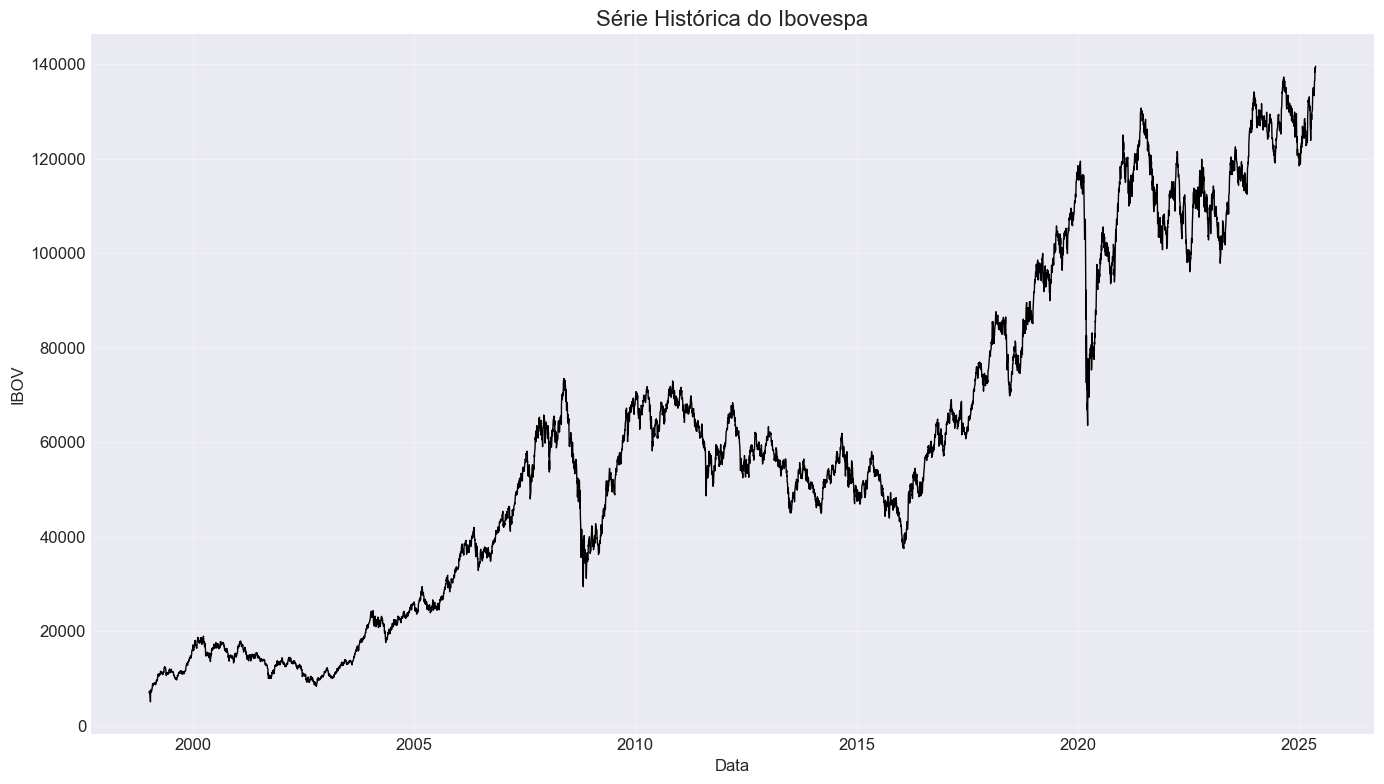

In [24]:
# Visualizing the Ibovespa historical series
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], color='#000000', linewidth=1)
plt.title('Série Histórica do Ibovespa', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('IBOV', fontsize=12)
plt.grid(True, alpha=0.3)

# Format the X axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## 3. Identificação de Máximas Históricas

Agora vamos criar uma função para identificar todas as datas em que o Ibovespa atingiu uma nova máxima histórica. Vamos incluir dois parâmetros para controlar a análise:

1. **waiting_period** (padrão: 30 dias): Período mínimo entre máximas históricas consecutivas
2. **min_candles** (padrão: 250 dias): Quantidade mínima de dados históricos necessários antes de começar a considerar máximas históricas

Esses parâmetros nos ajudarão a evitar a identificação de máximas históricas em períodos com poucos dados históricos e também a controlar a frequência de máximas consideradas.

In [25]:
def identify_all_time_highs(df, column='Close', waiting_period=30, min_candles=250):
    """
    Identifies all dates where the price reached a new all-time high,
    considering only highs that occurred after at least 'waiting_period' days from the last high
    and after 'min_candles' of data history.
    
    Args:
        df (pd.DataFrame): DataFrame with price data
        column (str): Name of the price column to analyze
        waiting_period (int): Minimum number of days between consecutive all-time highs
        min_candles (int): Minimum number of trading days required before considering ATHs
                            (helps to avoid early data points with limited history)
        
    Returns:
        pd.DataFrame: DataFrame with the dates and values of all-time highs
    """
    # Initialize variables
    current_max = float('-inf')
    last_high_date = None
    highs = []
    
    # Skip initial period based on min_candles
    start_idx = min(min_candles, len(df) - 1) if min_candles > 0 else 0
    
    # Iterate over the data, starting after the cooldown period
    for date, price in zip(df.index[start_idx:], df[column][start_idx:]):
        # Check if it's a new all-time high
        if price > current_max:
            # Check if it respects the waiting period
            if last_high_date is None or (date - last_high_date).days >= waiting_period:
                highs.append({'date': date, 'price': price})
                last_high_date = date
            current_max = price
    
    highs_df = pd.DataFrame(highs)
    
    return highs_df

In [26]:
# Configurable parameters
waiting_period = 30      # Buffer days between consecutive all-time highs
min_candles = 250  # Minimum trading days required before considering ATHs

highs_df = identify_all_time_highs(df, waiting_period=waiting_period, min_candles=min_candles)

# Display the identified highs
print(f"Total all-time highs found: {len(highs_df)}")
print(f"Starting analysis after {min_candles} trading days of data history")
print("\nFirst 5 all-time highs:")
print(highs_df.head(5))
print("\nLast 5 all-time highs:")
print(highs_df.tail(5))

Total all-time highs found: 44
Starting analysis after 250 trading days of data history

First 5 all-time highs:
        date     price
0 2000-01-07  16309.00
1 2000-02-07  18126.00
2 2000-03-27  18951.00
3 2003-11-14  18985.87
4 2003-12-18  21489.27

Last 5 all-time highs:
         date      price
39 2021-01-07  122385.90
40 2021-05-28  125561.40
41 2023-12-14  130842.09
42 2024-08-19  135777.98
43 2025-05-13  138963.11


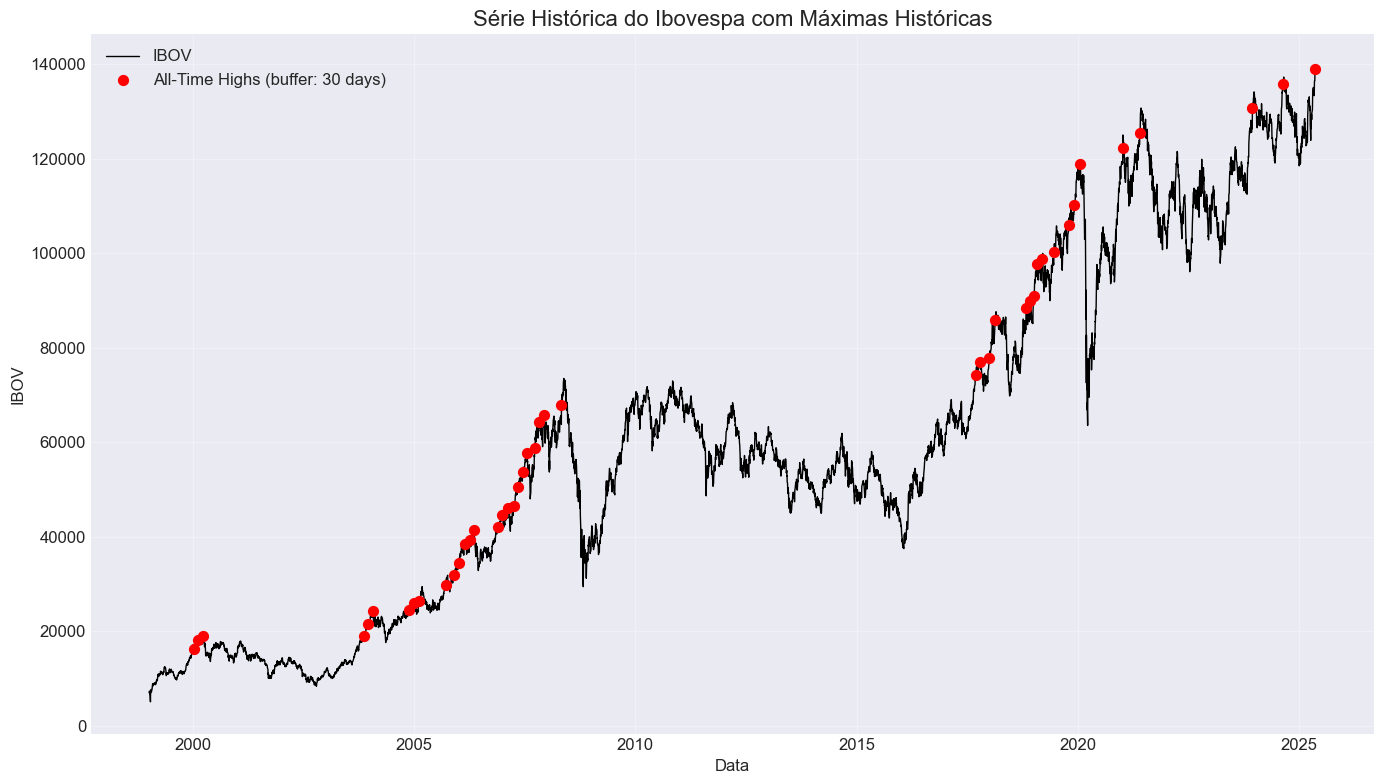

In [27]:
plt.figure(figsize=(14, 8))

# Plot Ibovespa historical series
plt.plot(df.index, df['Close'], color='#000000', linewidth=1, label='IBOV')

# Mark all-time highs
plt.scatter(highs_df['date'], highs_df['price'], color='red', s=50, zorder=5, label=f'All-Time Highs (buffer: {waiting_period} days)')

plt.title('Série Histórica do Ibovespa com Máximas Históricas', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('IBOV', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Format X axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## 4. Análise de Desempenho Após Máximas Históricas

Agora vamos analisar o desempenho do Ibovespa após cada máxima histórica. Vamos calcular o retorno acumulado para um período específico após cada máxima.

In [28]:
def calculate_performance_after_high(df, highs_df, holding_period=250):
    """
    Calculates market performance after each all-time high.
    
    Args:
        df (pd.DataFrame): DataFrame with price data
        highs_df (pd.DataFrame): DataFrame with the dates of all-time highs
        holding_period (int): Number of trading days to consider after each high
        
    Returns:
        dict: Dictionary with performance data for each all-time high
    """
    results = {}
    
    for i in range(len(highs_df)):
        high_date = highs_df.iloc[i]['date']
        high_price = highs_df.iloc[i]['price']
        
        # Find the index of the high date in the original DataFrame
        idx = df.index.get_indexer([high_date], method='nearest')[0]
            
        # Check if we have enough data after the high
        if idx + holding_period >= len(df):
            print(f"Insufficient data after the high on {high_date}. Skipping...")
            continue
        
        # Get prices for the analysis period
        period_prices = df['Close'].iloc[idx:idx + holding_period + 1].values
        normalized_prices = (period_prices / period_prices[0]) - 1  # Return relative to the high day
        
        # Create array with trading days (0, 1, 2, ..., holding_period)
        days = np.arange(len(normalized_prices))
        
        results[high_date] = {
            'days': days,
            'returns': normalized_prices,
            'high_price': high_price
        }
    
    return results

In [29]:
# Configurable parameters
holding_period = 250  # Trading days to analyze after each high

results = calculate_performance_after_high(df, highs_df, holding_period=holding_period)

print(f"Performance calculated for {len(results)} all-time highs.")

results

best_key = max(results, key=lambda k: results[k]['returns'][-1])
worst_key = min(results, key=lambda k: results[k]['returns'][-1])

best_run = results[best_key]
worst_run = results[worst_key]

# Create a DataFrame from the results dict
returns = pd.DataFrame([
    {'start': k, 'final_return': v['returns'][-1]}
    for k, v in results.items()
])

# Sort by final return
top5 = returns.sort_values('final_return', ascending=False).head(5)
bottom5 = returns.sort_values('final_return', ascending=True).head(5)

print("Top 5 Best Runs:")
print(top5.to_string(index=False))

print("\nTop 5 Worst Runs:")
print(bottom5.to_string(index=False))

Insufficient data after the high on 2024-08-19 00:00:00. Skipping...
Insufficient data after the high on 2025-05-13 00:00:00. Skipping...
Performance calculated for 42 all-time highs.
Top 5 Best Runs:
     start  final_return
2006-11-23      0.477457
2007-02-14      0.413251
2007-05-04      0.393405
2005-02-09      0.390051
2006-12-27      0.364858

Top 5 Worst Runs:
     start  final_return
2007-12-06     -0.422896
2007-10-26     -0.420358
2008-04-30     -0.261777
2000-03-27     -0.246363
2019-03-13     -0.164058


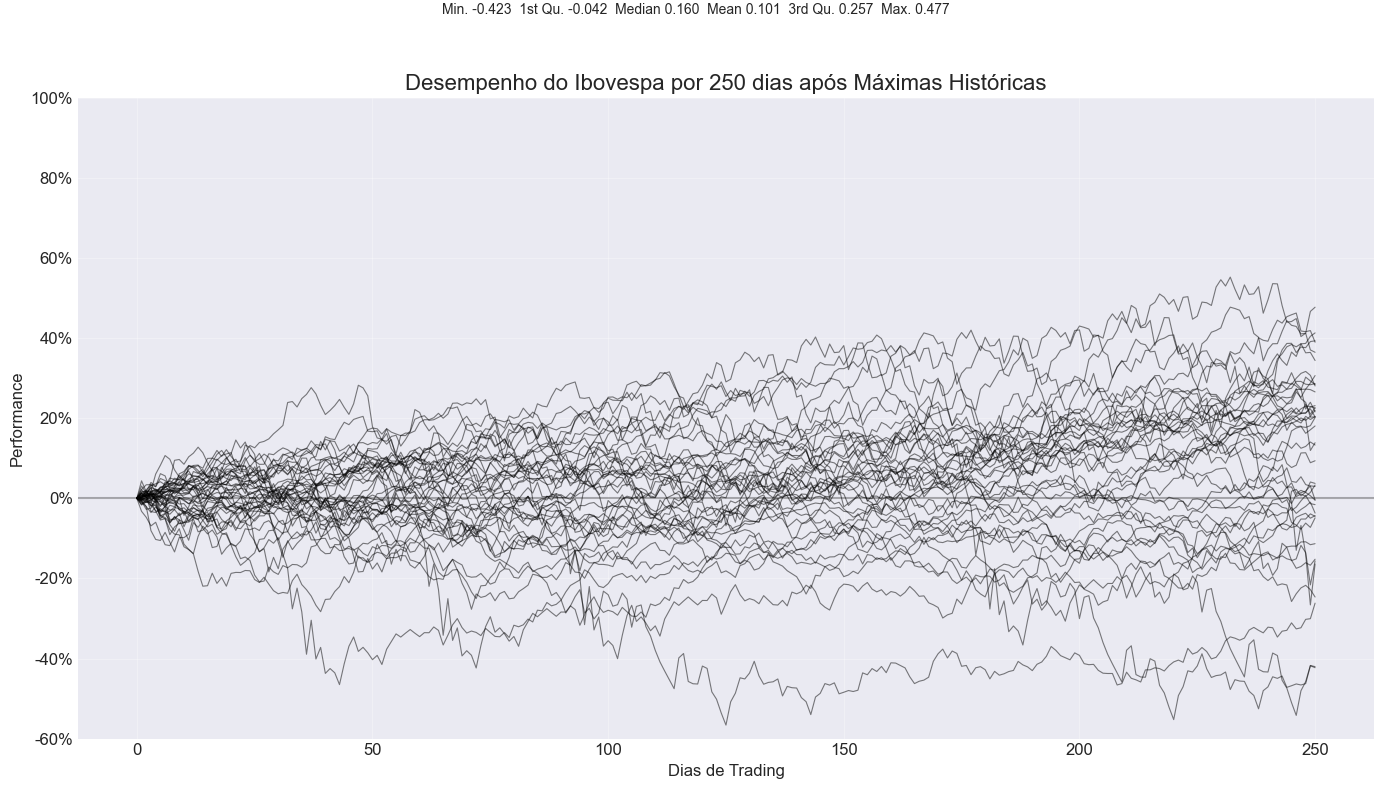

In [30]:
plt.figure(figsize=(14, 8))

# Statistics for the title
final_returns = [results[date]['returns'][-1] for date in results.keys()]
statistics = {
    'Min.': np.min(final_returns),
    '1st Qu.': np.percentile(final_returns, 25),
    'Median': np.median(final_returns),
    'Mean': np.mean(final_returns),
    '3rd Qu.': np.percentile(final_returns, 75),
    'Max.': np.max(final_returns)
}

# Plot each performance line
for date in results.keys():
    plt.plot(results[date]['days'], results[date]['returns'], color='black', alpha=0.5, linewidth=0.8)

# Add statistics to the graph
stats_text = "".join([f"{k} {v:.3f}  " for k, v in statistics.items()])
plt.annotate(stats_text, xy=(0.5, 0.97), xycoords='figure fraction', ha='center', fontsize=10)

# Format the graph
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title(f'Desempenho do Ibovespa por {holding_period} dias após Máximas Históricas', fontsize=16)
plt.xlabel('Dias de Trading', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.ylim(-0.6, 1.0)  # Adjust as needed
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()

## 5. Combinando em um subplot

Vamos unir os dois gráficos em um só para ficar semelhante ao tweet original.

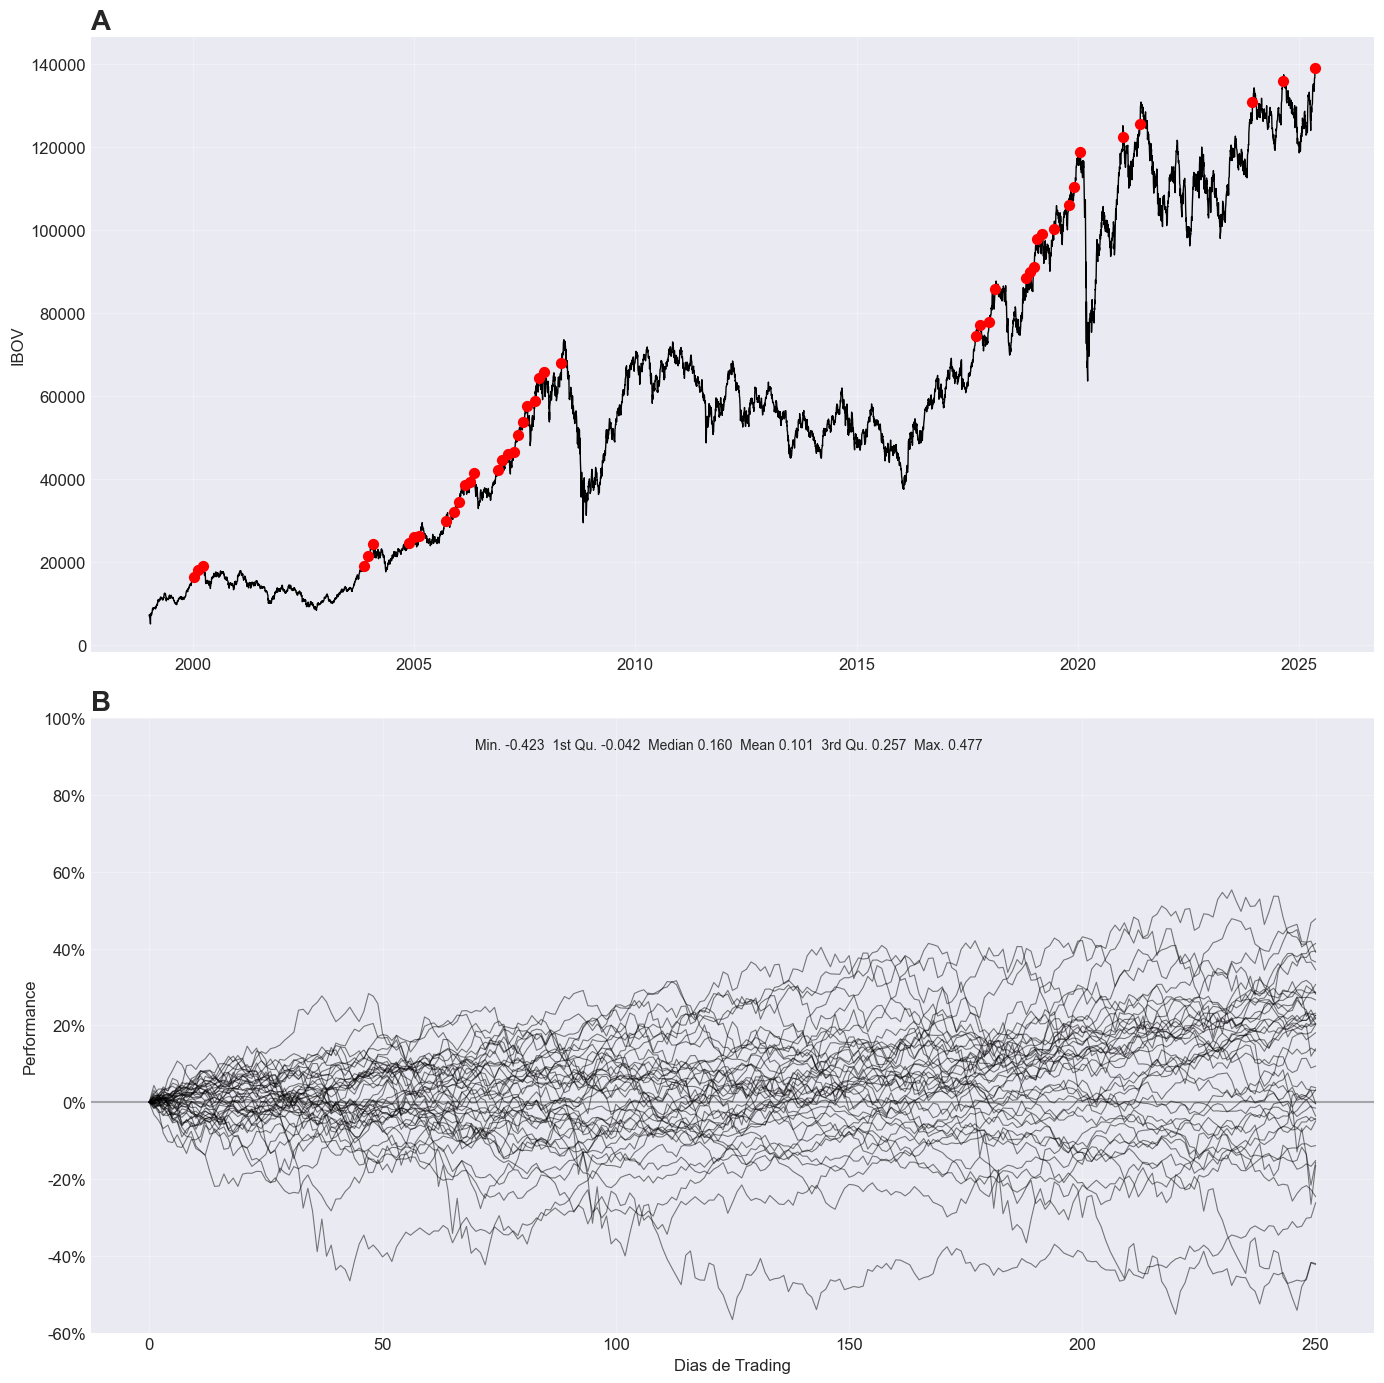

In [31]:
# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 1]})

# Graph A: Historical series with highs
axes[0].plot(df.index, df['Close'], color='#000000', linewidth=1)
axes[0].scatter(highs_df['date'], highs_df['price'], color='red', s=50, zorder=5)
axes[0].set_title('A', loc='left', fontsize=20, fontweight='bold')
axes[0].set_ylabel('IBOV', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_locator(mdates.YearLocator(5))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Graph B: Performance after highs
for date in results.keys():
    axes[1].plot(results[date]['days'], results[date]['returns'], color='black', alpha=0.5, linewidth=0.8)

# Add statistics to graph B
stats_text = "".join([f"{k} {v:.3f}  " for k, v in statistics.items()])
axes[1].annotate(stats_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10)

axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('B', loc='left', fontsize=20, fontweight='bold')
axes[1].set_xlabel('Dias de Trading', fontsize=12)
axes[1].set_ylabel('Performance', fontsize=12)
axes[1].set_ylim(-0.6, 1.0)  # Adjust as needed
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.show()

## 6. Juntando tudo em uma função configurável

Vamos criar uma função que permita executar a análise de uma só vez com diferentes parâmetros.

In [32]:
def analyze_performance_after_highs(df, waiting_period=30, holding_period=250, min_candles=250):
    """
    Executes the complete analysis of performance after all-time highs.
    
    Args:
        df (pd.DataFrame): DataFrame with price data
        waiting_period (int): Minimum number of days between consecutive all-time highs
        holding_period (int): Number of trading days to consider after each high
        min_candles (int): Minimum number of trading days required before considering ATHs
                            (helps to avoid early data points with limited history)
    """
    # Identify all-time highs
    highs_df = identify_all_time_highs(df, waiting_period=waiting_period, min_candles=min_candles)
    print(f"Total all-time highs found: {len(highs_df)}")
    print(f"Starting analysis after {min_candles} trading days of data history")
    
    # Calculate performance after each all-time high
    results = calculate_performance_after_high(df, highs_df, holding_period=holding_period)
    print(f"Performance calculated for {len(results)} all-time highs.")
    
    # Statistics for the title
    final_returns = [results[date]['returns'][-1] for date in results.keys()]
    statistics = {
        'Min.': np.min(final_returns),
        '1st Qu.': np.percentile(final_returns, 25),
        'Median': np.median(final_returns),
        'Mean': np.mean(final_returns),
        '3rd Qu.': np.percentile(final_returns, 75),
        'Max.': np.max(final_returns)
    }
    
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 1]})
    
    # Graph A: Historical series with highs
    axes[0].plot(df.index, df['Close'], color='#000000', linewidth=1)
    axes[0].scatter(highs_df['date'], highs_df['price'], color='red', s=50, zorder=5)
    axes[0].set_title('A', loc='left', fontsize=20, fontweight='bold')
    axes[0].set_ylabel('IBOV', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].xaxis.set_major_locator(mdates.YearLocator(5))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Graph B: Performance after highs
    for date in results.keys():
        axes[1].plot(results[date]['days'], results[date]['returns'], color='black', alpha=0.5, linewidth=0.8)
    
    # Add statistics to graph B
    stats_text = "".join([f"{k} {v:.3f}  " for k, v in statistics.items()])
    axes[1].annotate(stats_text, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10)
    
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('B', loc='left', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Dias de Trading', fontsize=12)
    axes[1].set_ylabel('Performance', fontsize=12)
    axes[1].set_ylim(-0.6, 1.0)  # Adjust as needed
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nEstatísticas do desempenho após máximas históricas:")
    for k, v in statistics.items():
        print(f"{k}: {v:.2%}")
    
    return highs_df, results, statistics

Total all-time highs found: 44
Starting analysis after 250 trading days of data history
Insufficient data after the high on 2023-12-14 00:00:00. Skipping...
Insufficient data after the high on 2024-08-19 00:00:00. Skipping...
Insufficient data after the high on 2025-05-13 00:00:00. Skipping...
Performance calculated for 41 all-time highs.


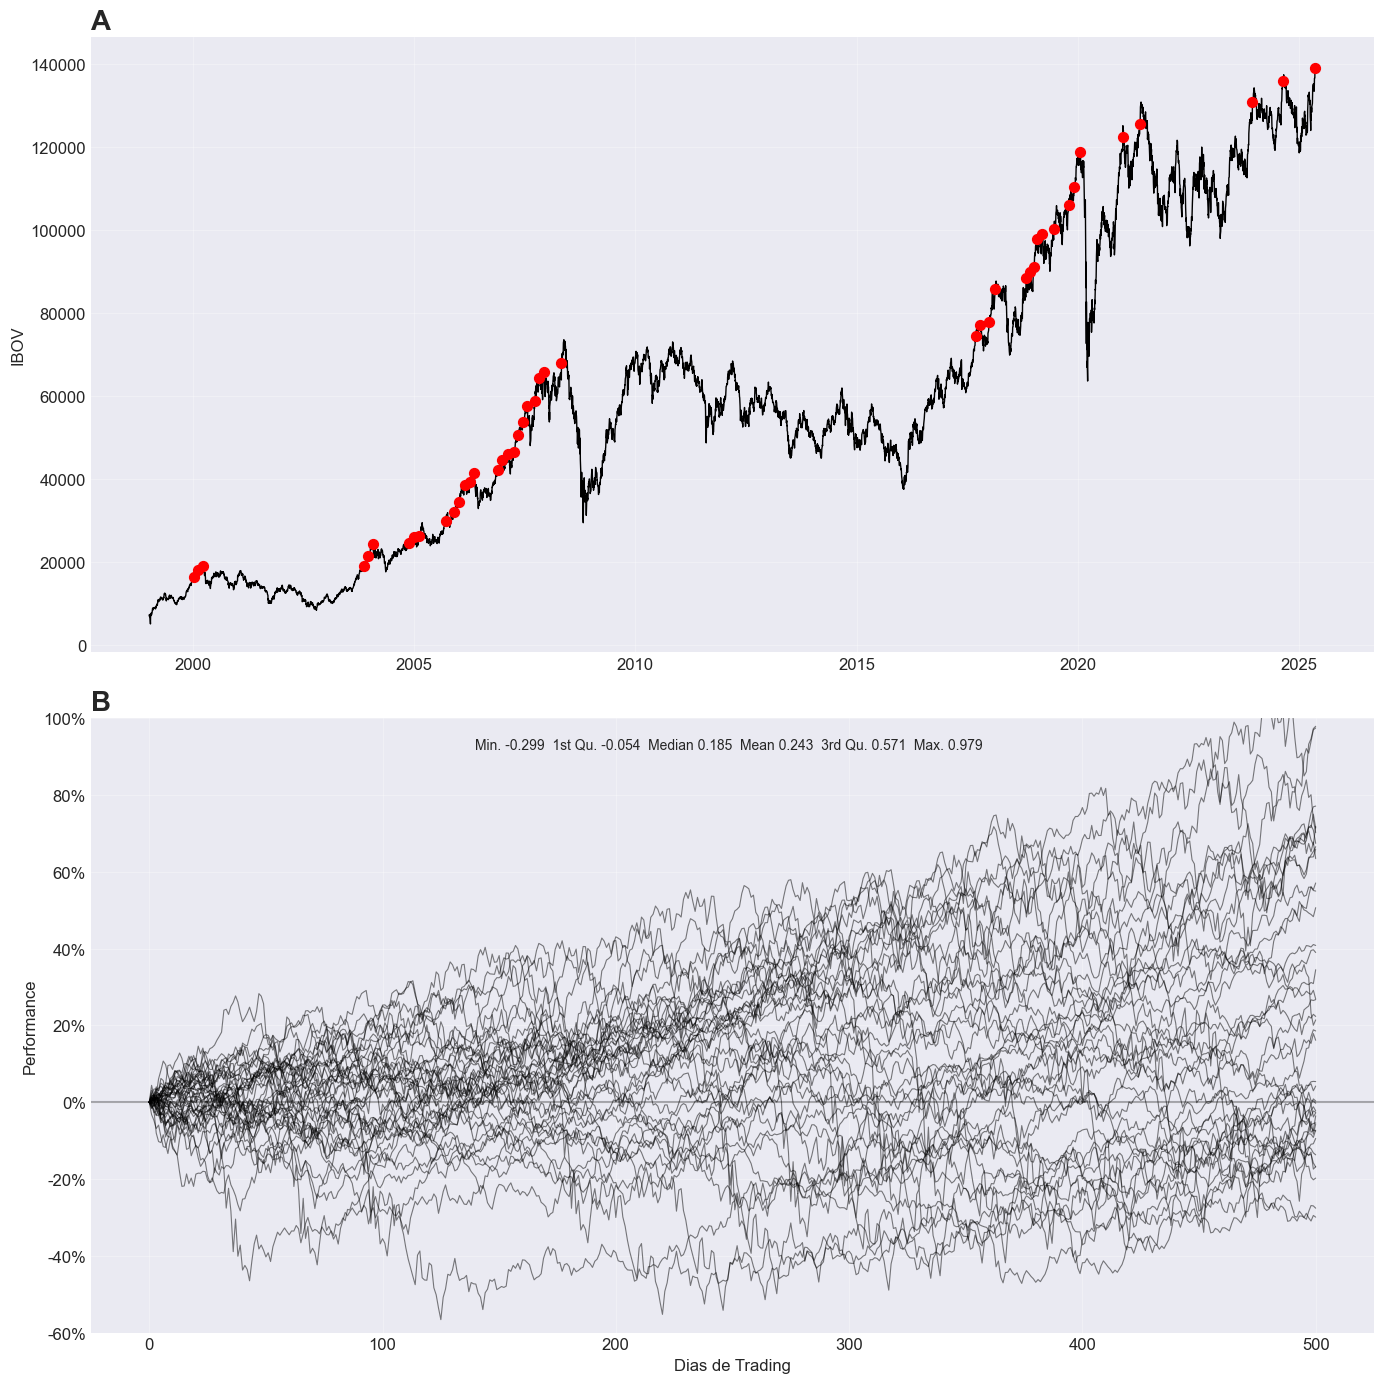


Estatísticas do desempenho após máximas históricas:
Min.: -29.94%
1st Qu.: -5.39%
Median: 18.54%
Mean: 24.29%
3rd Qu.: 57.05%
Max.: 97.85%


In [33]:
highs_df_500, results_500, statistics_500 = analyze_performance_after_highs(
    df, 
    waiting_period=30,       # Minimum days between ATHs
    holding_period=500,    # Longer analysis period (2 years)
    min_candles=250    # Minimum trading days required before considering ATHs
)

Total all-time highs found: 29
Starting analysis after 500 trading days of data history
Insufficient data after the high on 2024-08-19 00:00:00. Skipping...
Insufficient data after the high on 2025-05-13 00:00:00. Skipping...
Performance calculated for 27 all-time highs.


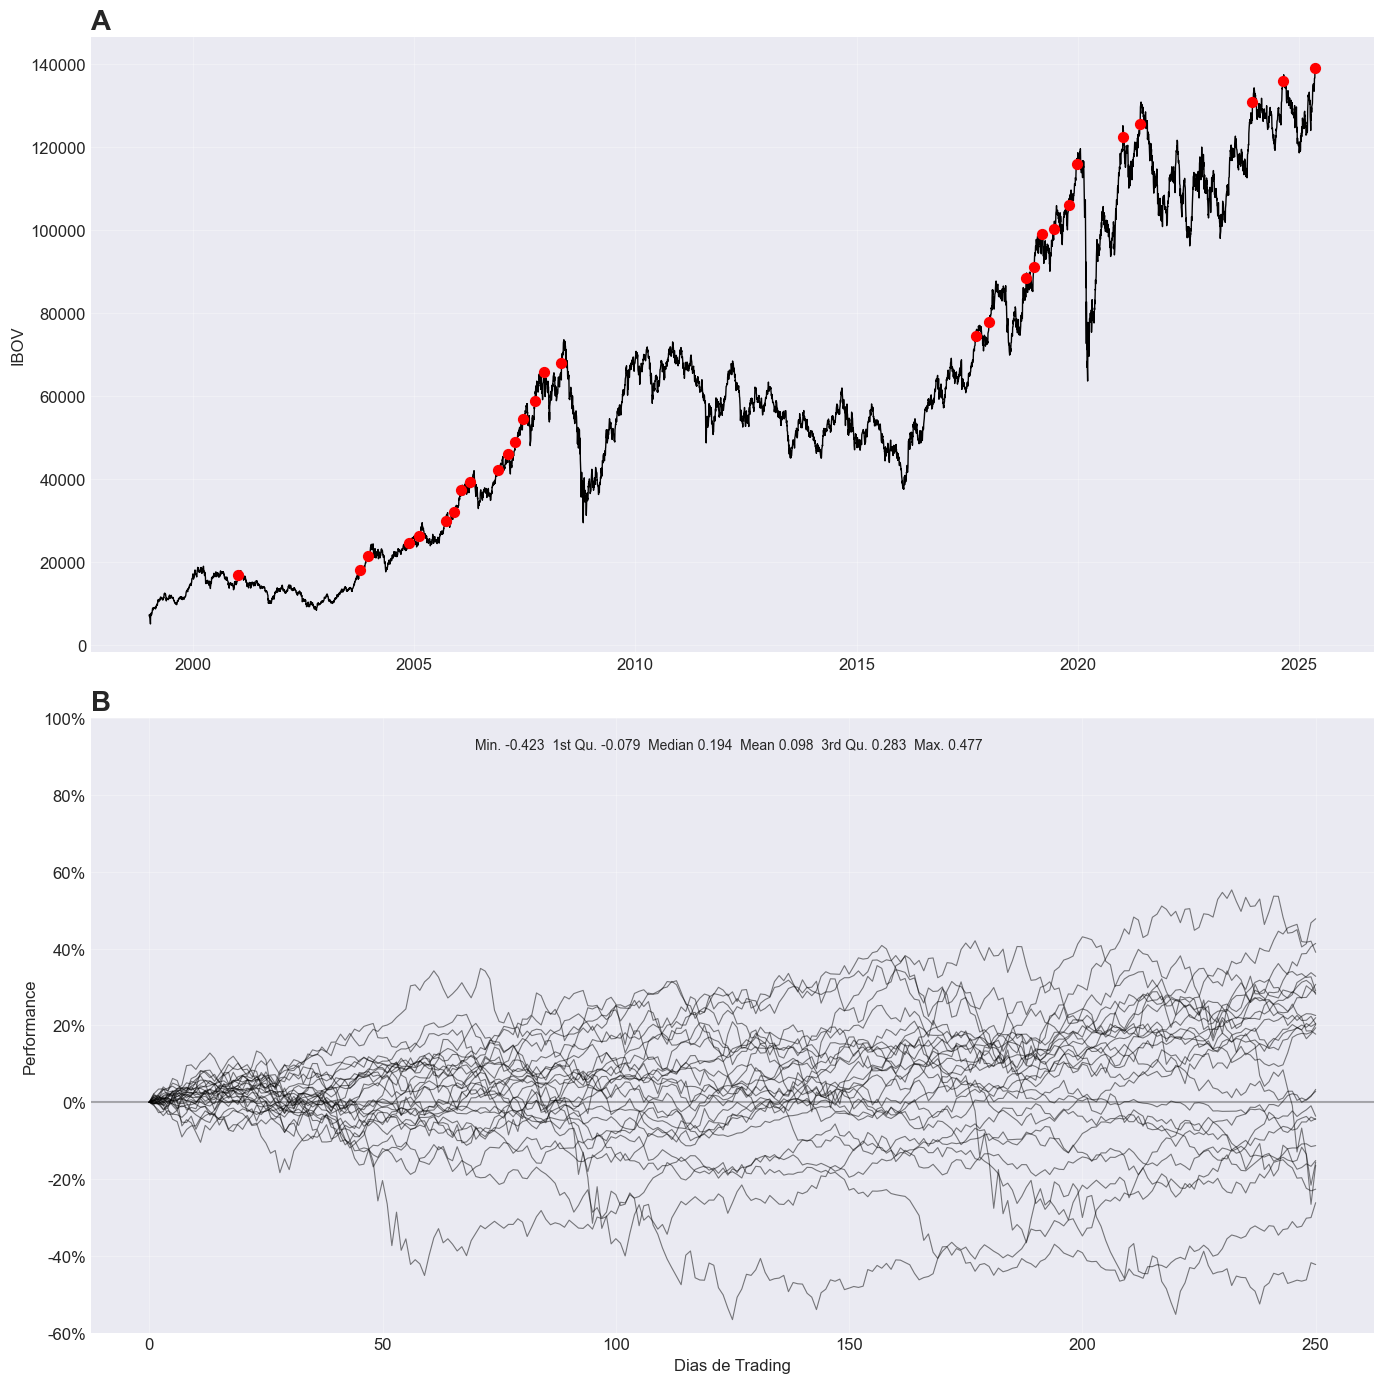


Estatísticas do desempenho após máximas históricas:
Min.: -42.29%
1st Qu.: -7.90%
Median: 19.37%
Mean: 9.76%
3rd Qu.: 28.25%
Max.: 47.75%


In [34]:
# Testing with longer cooldown period
highs_df_cool, results_cool, statistics_cool = analyze_performance_after_highs(
    df, 
    waiting_period=60,       # Minimum days between ATHs
    holding_period=250,    # Analysis period after each ATH
    min_candles=500    # Longer cooldown period (2 years of data before considering ATHs)
)